Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
github repository of the project.

# Watermarking Autoregressive Image Generation

[[`arXiv`](https://arxiv.org/abs/2506.16349)]
[[`Github`](https://colab.research.google.com/github/facebookresearch/wmar/blob/main/notebooks/colab.ipynb)]

This notebook is a minimal working example to generate watermarked images with RAR as in [Watermarking Autoregressive Image Generation](https://github.com/facebookresearch/wmar).

## Setup

The setup code below installs packages to the active env and downloads the model weights needed to run generation with RAR. For the full setup (other models, finetuning...) check `README.md`.

Clone repo:

In [2]:
!git clone https://github.com/facebookresearch/wmar.git
%cd wmar

Cloning into 'wmar'...
remote: Enumerating objects: 504, done.
remote: Counting objects: 100% (504/504), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 504 (delta 103), reused 500 (delta 101), pack-reused 0 (from 0)
Receiving objects: 100% (504/504), 4.12 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/wmar


Install requirements and download models:

In [3]:
!pip install numpy matplotlib webdataset loguru open_clip_torch==2.32.0 diffusers==0.33.1 torch_fidelity==0.3.0 torchinfo scikit-learn scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.34.0
    Uninstalling diffusers-0.34.0:
      Successfully uninstalled diffusers-0.34.0


In [4]:
!wget https://dl.fbaipublicfiles.com/watermark_anything/wam_mit.pth -P checkpoints/
!wget https://dl.fbaipublicfiles.com/wmar/finetunes/rar_encoder_ft_delta.pth -P checkpoints/finetunes/
!wget https://dl.fbaipublicfiles.com/wmar/finetunes/rar_decoder_ft_delta.pth -P checkpoints/finetunes/

--2025-08-27 00:07:59--  https://dl.fbaipublicfiles.com/watermark_anything/wam_mit.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377825938 (360M) [binary/octet-stream]
Saving to: ‘checkpoints/wam_mit.pth’

wam_mit.pth         100%[===================>] 360.32M   245MB/s    in 1.5s    

2025-08-27 00:08:01 (245 MB/s) - ‘checkpoints/wam_mit.pth’ saved [377825938/377825938]

--2025-08-27 00:08:01--  https://dl.fbaipublicfiles.com/wmar/finetunes/rar_encoder_ft_delta.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95125959 (91M) [binary/octet-stream]
Saving to: ‘checkpoi

## Load a model and generate some watermarked images

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch

from wmar.models.rar_wrapper import RarARMMWrapper
from wmar.utils.utils import update_weights, add_code_to_plot
from wmar.watermarking.gentime_watermark import create_watermarker_from_string
from wmar.watermarking.synchronization import SyncManager
from wmar.augmentations.geometric import Rotate
from wmar.augmentations.valuemetric import JPEG

attention mode is flash


/content/wmar/deps/rar/modeling/modules/losses.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/wmar/deps/rar/modeling/quantizer/quantizer.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/wmar/deps/rar/modeling/quantizer/quantizer.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/wmar/deps/rar/modeling/quantizer/quantizer.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/content/wmar/deps/rar/modeling/quantizer/quantizer.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', ar

### Set up the autoregressive model and the watermarking framework.

This code loads the RAR model and updates the weights of the decoder and the encoder replica using deltas from RCC finetuning.
It also sets the watermarking parameters and sets up the synchonization layer.

(Note that in this example we use the small RAR-B variant; our experiments in the paper use the bigger RAR-XL)

In [1]:
!nvidia-smi

Wed Aug 27 00:07:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# Load original model
model = RarARMMWrapper(modelpath = "checkpoints/", rar_size="rar_b")

# Patch and initialize the watermark
update_weights(model.get_image_tokenizer().encoder, "checkpoints/finetunes/rar_encoder_ft_delta.pth")
update_weights(model.get_image_tokenizer().decoder, "checkpoints/finetunes/rar_decoder_ft_delta.pth")
watermarker = create_watermarker_from_string(
    model.get_vq(),
    model.get_total_vocab_size(),
    "linear-stratifiedrand-h=1-d=2.0-g=0.25",
    "cuda")
model.set_watermarker(watermarker)
sync_manager = SyncManager("checkpoints/wam_mit.pth", device="cuda")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


maskgit-vqgan-imagenet-f16-256.bin:   0%|          | 0.00/218M [00:00<?, ?B/s]

rar_b.bin:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 79.9MB/s]


8.19kB [00:00, 593kB/s]                    


loaded pretrained LPIPS loss from checkpoints/lpips/vgg.pth
Loaded alive ids: 1024
Codes size: 16, Image size: 256, Dim z: 256


2025-08-27 00:09:19.850 | DEBUG    | wmar.utils.utils:update_weights:65 - Missing: []
2025-08-27 00:09:19.851 | DEBUG    | wmar.utils.utils:update_weights:66 - Unexpected: []
2025-08-27 00:09:20.527 | DEBUG    | wmar.utils.utils:update_weights:65 - Missing: []
2025-08-27 00:09:20.528 | DEBUG    | wmar.utils.utils:update_weights:66 - Unexpected: []


Greenlist size: 256 for vocab sz 1024 and gamma 0.25
making attention of type 'vanilla' with 64 in_channels
Working with z of shape (1, 68, 32, 32) = 69632 dimensions.
making attention of type 'vanilla' with 64 in_channels
Model loaded successfully from checkpoints/wam_mit.pth
{'embedder_config': 'deps/watermark_anything/configs/embedder.yaml', 'augmentation_config': 'deps/watermark_anything/configs/all_augs_multi_wm.yaml', 'extractor_config': 'deps/watermark_anything/configs/extractor.yaml', 'attenuation_config': 'deps/watermark_anything/configs/attenuation.yaml', 'embedder_model': 'vae_small', 'extractor_model': 'sam_base', 'nbits': 32, 'img_size': 256, 'img_size_extractor': 256, 'attenuation': 'jnd_1_3_blue', 'scaling_w': 2.0, 'scaling_w_schedule': None, 'scaling_i': 1.0, 'roll_probability': 0.2, 'multiple_w': 1.0, 'nb_wm_eval': 5, 'optimizer': 'AdamW,lr=1e-4', 'optimizer_d': None, 'scheduler': 'CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', 'epochs': 2

### Generate images with RAR-B conditioned on the ImageNet class 975 ("Lakeside").

We generate an unwatermarked image and a watermarked image, and run the watermark detector on both, as well as the transformed variants of the watermarked image (JPEG, rotation).

The rightmost column illustrates the tokens ultimately received by the watermark detector. These should be interpreted as follows:
- The **shape** (square 🟥 or cross ❌) indicates if the token is reverse cycle-consistent. Every square token *matches the token that was originally generated by the model at that position* while every cross token does not.
- Independently, the **color** (green 🟩, red 🟥, white ⬜) indicates the color assigned to the token by the watermark detector following the rules of the Red/Green scheme. White tokens are those that are ignored by the detector due to duplication or insufficient context.

We see that watermarked images have more green tokens and are detected as watermarked (*low p-values*) even after augmentations.

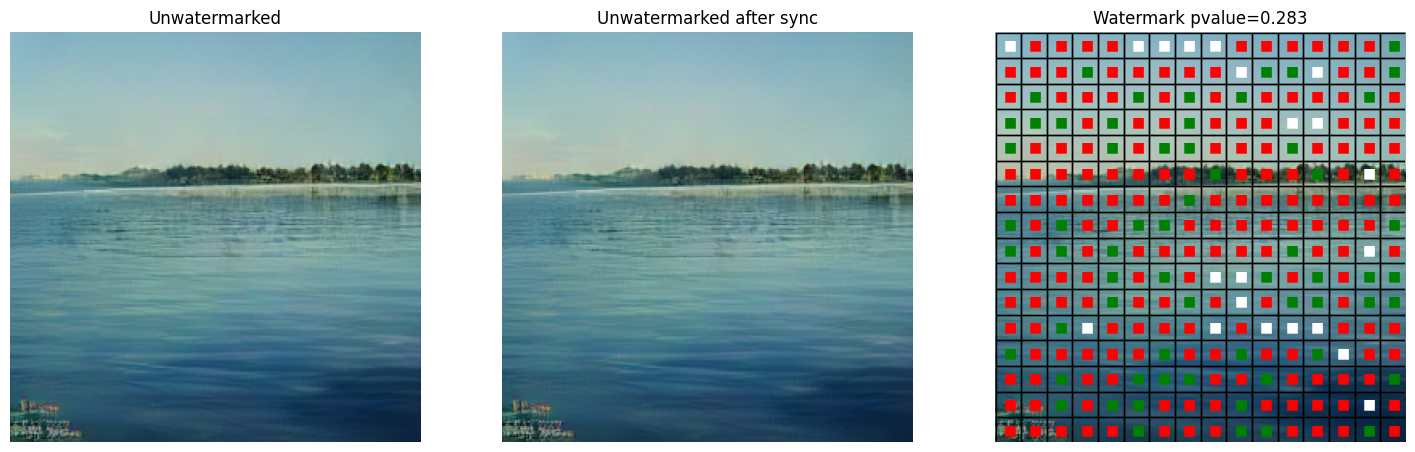

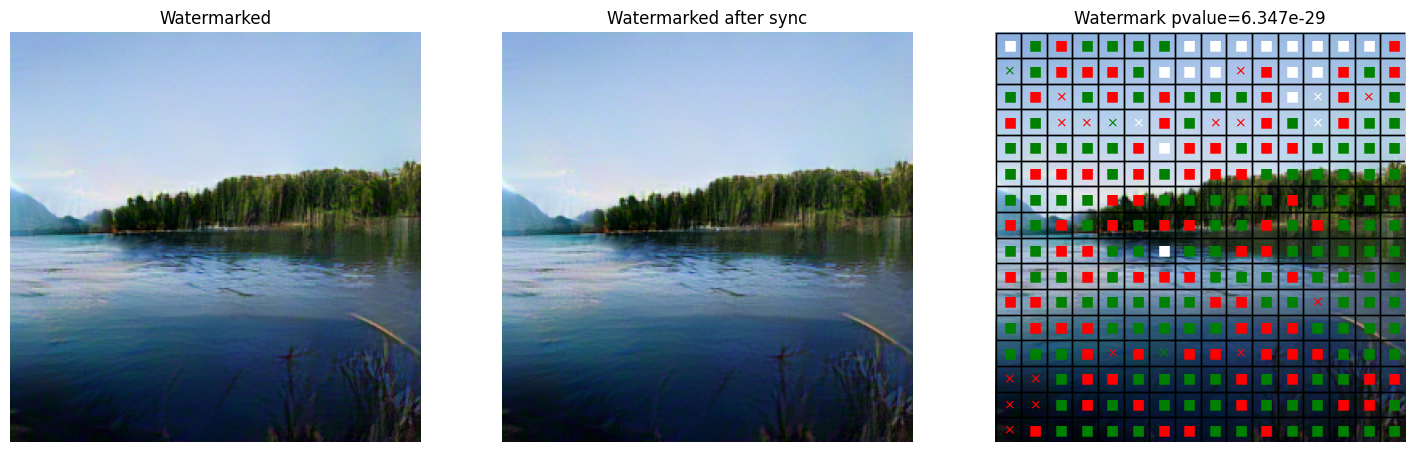

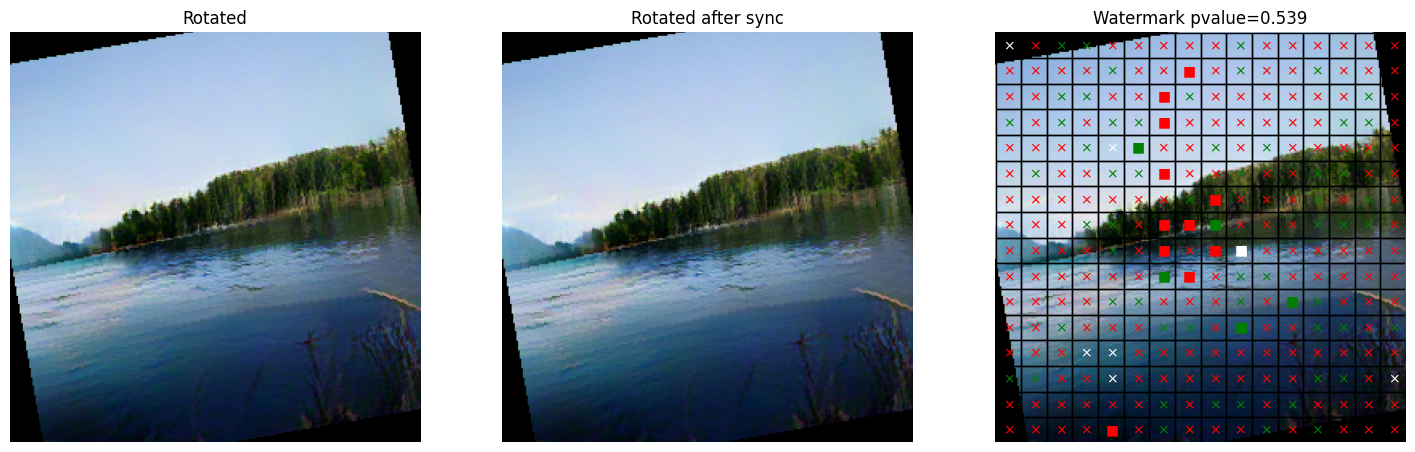

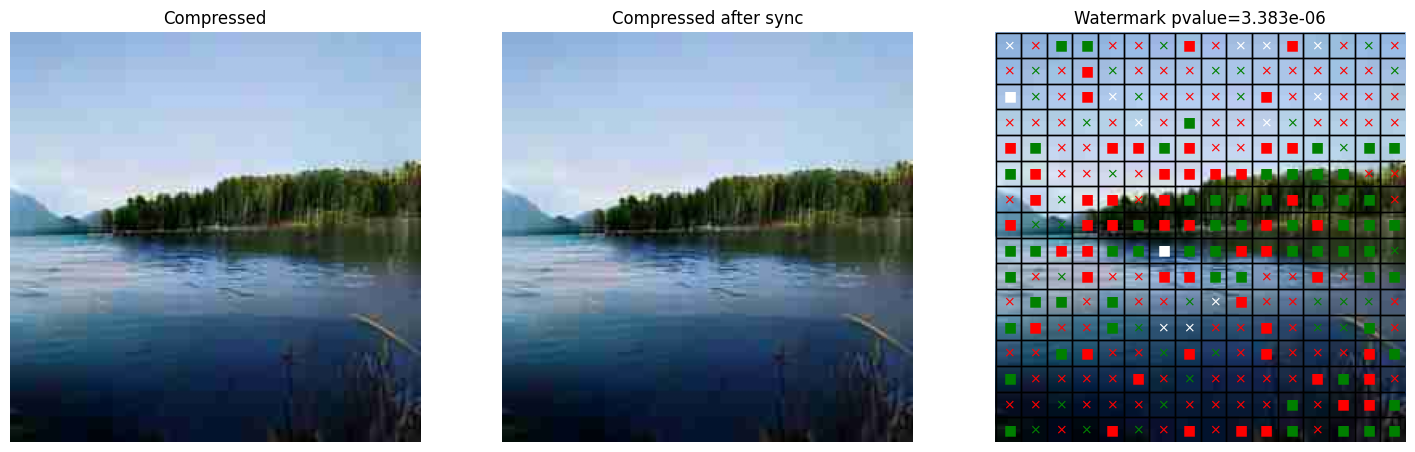

In [9]:
seed = 16
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def img2np(img):
    return (img/2.0+0.5).permute(1, 2, 0).cpu().numpy()

def show(key, orig_codes, imgs, model, watermarker, sync_manager):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img2np(imgs[0]))
    plt.axis('off')
    plt.title(f"{key}")

    plt.subplot(1, 3, 2)

    # imgs_nosync = sync_manager.remove_wam(imgs)
    imgs_nosync = imgs

    plt.imshow(img2np(imgs_nosync[0]))
    plt.axis('off')
    plt.title(f"{key} after sync")

    plt.subplot(1, 3, 3)
    plt.imshow(img2np(imgs_nosync[0]))
    codes = model.images_to_codes(imgs_nosync).detach()
    pval = watermarker.detect(codes)[0].cpu().item()
    add_code_to_plot(orig_codes[0], codes[0], watermarker)
    plt.axis('off')
    if pval > 0.01:
        plt.title(f"Watermark pvalue={pval:.3f}")
    else:
        plt.title(f"Watermark pvalue={pval:.3e}")
    plt.show()


gen_params = {"batch_size": 1, "temperature": 0.8, "top_k": 250, "top_p": 0.92}
class_conditioning = torch.tensor([[975]]) # Lakeside
# Generate some nowm images
nowm_codes = model.sample(class_conditioning, gen_params, apply_watermark=False).detach()
nowm_imgs = model.codes_to_images(nowm_codes).detach()
show("Unwatermarked", nowm_codes, nowm_imgs, model, watermarker, sync_manager)

# Sample and decode to image
orig_codes = model.sample(class_conditioning, gen_params, apply_watermark=True).detach()
orig_imgs = model.codes_to_images(orig_codes).detach()

# orig_imgs_with_sync = sync_manager.add_wam(orig_imgs).detach()
orig_imgs_with_sync = orig_imgs

show("Watermarked", orig_codes, orig_imgs_with_sync, model, watermarker, sync_manager)

# Augmentations?
def apply_augmentation(imgs, aug_fn, aug_param):
    return aug_fn(imgs/2.0+0.5, aug_param).clamp(0, 1)*2.0-1.0

rotated = apply_augmentation(orig_imgs_with_sync, Rotate(), 10)
show("Rotated", orig_codes, rotated, model, watermarker, sync_manager)

noised = apply_augmentation(orig_imgs_with_sync, JPEG(), 20)
show("Compressed", orig_codes, noised, model, watermarker, sync_manager)